In [132]:
import arch
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from scipy.stats import t
from scipy.stats import genextreme as gev

In [27]:
df = pd.read_csv("/Users/quinnhollister/Downloads/intel_d_logret.txt", delim_whitespace = True, header = None,
           parse_dates = True)
df.rename(columns = {0: "Date", 1: "logret"}, inplace = True)
df.head(100)

,Date,logret
0,7/10/1986,-0.024692
1,7/11/1986,-0.105360
2,7/14/1986,0.000000
3,7/15/1986,0.000000
4,7/16/1986,-0.028171
...,...,...
95,11/21/1986,0.025318
96,11/24/1986,0.024692
97,11/25/1986,0.024097
98,11/26/1986,0.023530


In [12]:
#For any VAR calculation using parametric models, lets calculate mean and std. deviation. 
#We'll also need to develop statistics to calculate other paramaters assuming the log-return distribution is of 
#a different family, i.e. GARCH, ARMA, GEV, etc...

sample_mean = np.mean(df["logret"])
sample_var = np.var(df["logret"])

print(sample_mean, sample_var)

0.0007683045589569133 0.000779885633947206


For part c, lets model the log returns as an ARMA(1,1)-GARCH(1,1) process with the residuals coming from the student t-distribution. So, our model looks like: 

$$r_{t} = \phi_{0} + \phi_{1} \cdot r_{t-1} + u_{t} + \psi_{1} \cdot u_{t-1} $$


$$\sigma_{t}^{2} = \omega + \alpha_{1} \cdot u_{t-1}^{2} + \beta_{1} \cdot \sigma_{t-1}^{2} $$

where $u_{t} = \sigma_{t} \epsilon_{t} $ and $\epsilon_{t} \sim t_{v}$
Thus, the ARMA process models the conditional mean, and the GARCH process models the conditional variance present in the resdiuals of the ARMA estimation. Note: ARMA estimates are generally inconsistent, so this approach may contaminate the GARCH estimates. 

In [29]:
#Technically the error terms are WN, i.e. gaussian?
arma_model = sm.tsa.arima.model.ARIMA(df["logret"], order = (1,0,1))
res = arma_model.fit()
print(res.summary())
arma_residuals = res.resid

/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 logret   No. Observations:                 5292
Model:                 ARIMA(1, 0, 1)   Log Likelihood               11427.115
Date:                Tue, 09 Nov 2021   AIC                         -22846.229
Time:                        11:42:58   BIC                         -22819.934
Sample:                             0   HQIC                        -22837.040
                               - 5292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.922      0.055    -1.5e-05       0.002
ar.L1          0.0062      0.781      0.008      0.994      -1.525       1.538
ma.L1          0.0062      0.782      0.008      0.9

In [31]:
#Now lets fit the arma residuals to the GARCH process with t-student innovations
archm = arch.arch_model(arma_residuals, p =1, q = 1, dist = 'StudentsT')
arch_model_fitted = archm.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 300993.56410584296
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6448867.475267628
Iteration:      3,   Func. Count:     39,   Neg. LLF: 29142.954200103683
Iteration:      4,   Func. Count:     49,   Neg. LLF: 28908.623872559783
Iteration:      5,   Func. Count:     56,   Neg. LLF: 15996.717887353032
Iteration:      6,   Func. Count:     62,   Neg. LLF: 8440393.362285664
Iteration:      7,   Func. Count:     71,   Neg. LLF: 11539.962043433605
Iteration:      8,   Func. Count:     77,   Neg. LLF: 4425.602633615926
Iteration:      9,   Func. Count:     83,   Neg. LLF: 9907.666222509128
Iteration:     10,   Func. Count:     90,   Neg. LLF: 830.3782335694592
Iteration:     11,   Func. Count:     97,   Neg. LLF: 225748.1418010156
Iteration:     12,   Func. Count:    113,   Neg. LLF: 112911.17482360976
Iteration:     13,   Func. Count:    119,   Neg. LLF: 558025.5083287237
Iteration:     14,   Func. Count:    131,   Neg. LLF: 1095

/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007798. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [44]:
arch_model_fitted

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8069.58
Distribution:      Standardized Student's t   AIC:                           16149.2
Method:                  Maximum Likelihood   BIC:                           16182.0
                                              No. Observations:                 5292
Date:                      Tue, Nov 09 2021   Df Residuals:                     5291
Time:                              11:44:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [52]:
#need to extract out the df for the student-t error:
nu = arch_model_fitted.optimization_result.x[-1]
mu = arch_model_fitted.optimization_result.x[0]
print(mu)

0.04444825542857589


Now that we have our model fitted, we can forecast for k-steps ahead in order to get the VAR calculations. Let's begin with the 1-day calculation. 

$$ \hat{r}_{t+1|t} = \phi_{0} + \phi_{1}r_{t} + \psi_{1}u_{t} $$ 
$$ \hat{\sigma}_{t+1|t}^{2} = \omega + \alpha_{1}u_{t}^{2} + \beta_{1}\sigma_{t}^{2} $$

However, from our model fitting, we have values for $u_{t}, \phi_{0}, \phi_{1}, \psi_{1}, \alpha_{1}, \beta_{1}, \sigma_{t}$. Thus, we can "plug-in" our estimates and calculate the 99% 1-day VAR estimates by using:

$$ \hat{r}_{t+1|t} - \hat{\sigma}_{t+1|t} \cdot z_{1-\alpha} $$ 

where $z_{1-\alpha}(\nu)$ is just the inverse CDF value of the 0.01 quantile of the standardized-t distribution with parameters found in the arch fitting. 

In [127]:
#Now lets forecast the next-1 period mean and variance so as to get 99% 1-day VAR
ALPHA = 0.99


mu_pred_1 = res.forecast().item()
et_pred_1 = arch_model_fitted.forecast(horizon=1).mean['h.1'].iloc[-1]
z = t.ppf(1-ALPHA, df = nu)

oneVAR = mu_pred_1 + et_pred_1*z
print("99% one day VAR for a portfolio of $1 Million:  $" + str(round(abs(oneVAR)*1000000, 2)))

99% one day VAR for a portfolio of $1 Million:  $155035.64


We know that $\hat{\sigma}_{t+k|t}^2 = \sum_{i=1}^{k}{\psi_{k-i}^{2} E[\sigma_{t+i}^{t} | F_{t}]} $ 


In [93]:
INDEX = 5301 #corresponds to 10th step ahead forecast



mu_pred_10 = res.get_forecast(steps=10).predicted_mean[INDEX]
et_pred_10

           h.1
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
...        ...
5287       NaN
5288       NaN
5289       NaN
5290       NaN
5291  0.044448

[5292 rows x 1 columns]


/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Now, we'll recalculate these VAR quanities but instead using the GEV distribution with a subperiod length of 20 trading days. 

In [100]:
#First, let's split our data into subsamples with width of 20 days, and selecting the 
#minimum values from these samples
PER_LENGTH = 20
PERIODS = int(len(df)/PER_LENGTH)

subperiod = []
for i in range(0, PERIODS):
    sub = df['logret'].take([i*20, (i+1)*20])
    subperiod.append(min(sub))
    
#We possibly didn't include some of the values at the end of our data
if len(df) % PER_LENGTH != 0:
    lastPer = df['logret'].take([PER_LENGTH*PERIODS, -1])
    subperiod.append(min(lastPer))


Minimum Value in Whole Data: -0.164301953
Shape: 0.49251829127051816
Loc: -0.023796742549085637
Scale: 0.02989782912918367


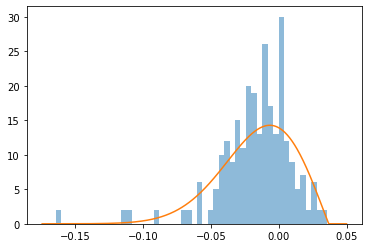

In [128]:
#now lets fit this data to a GEV distribution

plt.hist(subperiod, bins = 50, alpha = 0.5)

print("Minimum Value in Whole Data: " + str(min(subperiod)))

#need to specify good inital location, otherwise might be zero and that leads to bad fit.
params = gev.fit(subperiod, loc = 0.05)


print("Shape: " + str(params[0]))
print("Loc: " + str(params[1]))
print("Scale: " + str(params[2]))



shape = params[0]
loc = params[1]
scale = params[2]

xx = np.linspace(min(subperiod)-0.01, 0.05, 500)
plt.plot(xx, gev.pdf(xx, *params))

From https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.596.39&rep=rep1&type=pdf, we can see that given our shape, location, and scale parameters $\xi_{n}, \beta_{n}, \alpha_{n}$, we can write our 1-Day VAR formula as: 

$$ VaR = \beta_{n} - \frac{\alpha_{n}}{\xi_{n}} \{ 1 - [-n \cdot ln(1-p)]^{-\xi_{n}} \} $$

And, n is the length of the sub-period, so for us, n = 20

In [140]:
gevOneVar = loc
gevOneVar -= (scale/shape)*(1 - (-1*PER_LENGTH*math.log(1-ALPHA))**(-1*shape))
print("99% one day VAR for a portfolio of $1 Million with GEV:  $" + str(round(abs(gevOneVar)*1000000, 2)))

99% one day VAR for a portfolio of $1 Million with GEV:  $77957.76
